In [85]:
# Imports

import os
import pandas as pd 
import numpy as np
import sys
from tqdm import tqdm
from loguru import logger
from pathlib import Path
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Local imports
sys.path.append(r"./utils")
from utils import utils

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [86]:
# Constants

SAMPLE = True
DRY_RUN = False
DEBUG = True

GROUP_NAME = "EDA"

DATA_DROP_COLS = \
           ['Unnamed: 0', # index columns
            'userid', # index equivalent column 
            'pol_dat_us', # redundant columns with label
            'pol_dat_ca', # redundant columns with label
            'pol_dat_uk', # redundant columns with label
            'pol_fb_us', # redundant columns with label
            ]

DATA_DIR = "./data/full/"
RESULTS_DIR = f"./results/full/{GROUP_NAME}"

if SAMPLE:
  DATA_DIR = "./data/sample/"
  RESULTS_DIR = f"./results/sample/{GROUP_NAME}/"
  DATA_SHAPE_0 = 31742
  DATA_SHAPE_1 = 2092
  DATA_DROP_COLS = DATA_DROP_COLS \
                  + ['Unnamed: 0.1'] #TODO: Regenerate sample with index=False and remove this


logger.debug(f"Started the script for {GROUP_NAME}.")

2021-08-17 22:09:24.775 | DEBUG    | __main__:<module>:38 - Started the script for EDA.


In [87]:
# Read datasets

folders = os.listdir(DATA_DIR)
dataframes = []
for folder in tqdm(folders):
  logger.debug(f"In folder {folder}.")
  csv_files = os.listdir(DATA_DIR + folder)
  for csv in csv_files:
    if '.csv' in csv:
      logger.debug(DATA_DIR + folder + "/" + csv)
      df = pd.read_csv(DATA_DIR + folder + "/" + csv)
      dataframes.append(df)

data = pd.concat(dataframes, axis = 0)
del df, dataframes
logger.debug(f"Data size is {data.shape}")
if SAMPLE: assert (data.shape[0] == DATA_SHAPE_0) and (data.shape[1] == DATA_SHAPE_1), "Error: data shape is not correct!"

  0%|          | 0/9 [00:00<?, ?it/s]2021-08-17 22:09:24.813 | DEBUG    | __main__:<module>:6 - In folder UK_0_dating.
2021-08-17 22:09:24.814 | DEBUG    | __main__:<module>:10 - ./data/sample/UK_0_dating/segment_united kingdom_0_dating_black.csv
2021-08-17 22:09:25.279 | DEBUG    | __main__:<module>:10 - ./data/sample/UK_0_dating/segment_united kingdom_0_dating_asian.csv
2021-08-17 22:09:25.720 | DEBUG    | __main__:<module>:10 - ./data/sample/UK_0_dating/segment_united kingdom_0_dating_india.csv
2021-08-17 22:09:26.163 | DEBUG    | __main__:<module>:10 - ./data/sample/UK_0_dating/segment_united kingdom_0_dating_white.csv
 11%|█         | 1/9 [00:01<00:14,  1.85s/it]2021-08-17 22:09:26.667 | DEBUG    | __main__:<module>:6 - In folder Canada_1_dating.
2021-08-17 22:09:26.668 | DEBUG    | __main__:<module>:10 - ./data/sample/Canada_1_dating/segment_canada_1_dating_asian.csv
2021-08-17 22:09:27.118 | DEBUG    | __main__:<module>:10 - ./data/sample/Canada_1_dating/segment_canada_1_dating_

In [88]:
# Clean the data
data = data.drop(DATA_DROP_COLS, axis=1)

In [89]:
# converting gender to appropriate label { 0 : " FEMALE", 1 : "MALE"}

data['gender'] = data['gender'].replace({ 0 : " FEMALE", 1 : "MALE"})
data['gender.value'] = data['gender.value'].replace({ 0 : " FEMALE", 1 : "MALE"})


# prepare and clean data

# EDA 

In [90]:
def stats(df, param, location):
  '''
  Function to plot the column distribution plots

  Parameters : 
    - df ( DataFrame ) : Dataframe the analysis is conducted 
    - param ( str ) : column name to get the distribution
    - location ( str ) : location to save the plots. (RESULTS_DIR)
  
  Return:
    - prints the distribution 
    - Shows the plot 
    - saves it at the desired location
  '''

  print("Stats")
  print(round(df[param].value_counts()/df.shape[0],2)*100)

  print()
  title = "Distribution of {}".format(param)
  sns.countplot(x= param, data= df)
  plt.title("Distribution of {} ".format(param))
  plt.savefig(location+title+".png")



Stats
liberal         65.0
conservative    35.0
Name: pol, dtype: float64



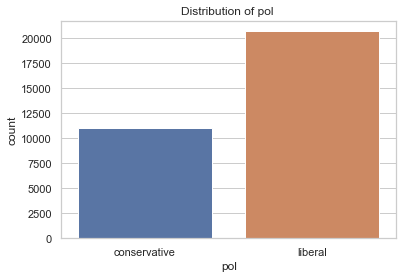

In [91]:
param = 'pol'

stats(data, param, RESULTS_DIR)

Stats
dating    75.0
fb        25.0
Name: database, dtype: float64



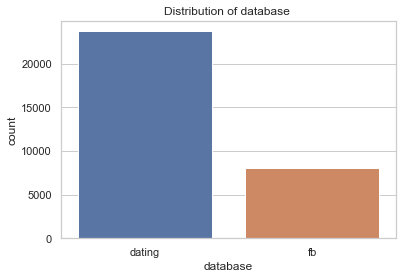

In [92]:
param = 'database'

stats(data, param, RESULTS_DIR)

Stats
united states     50.0
canada            25.0
united kingdom    24.0
Name: country, dtype: float64



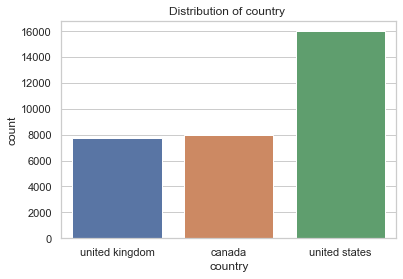

In [93]:
param = 'country'

stats(data, param, RESULTS_DIR)

Stats
 FEMALE    50.0
MALE       50.0
Name: gender, dtype: float64



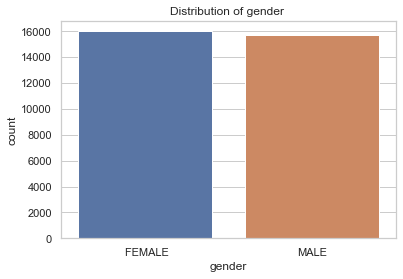

In [94]:
param = 'gender'

stats(data, param, RESULTS_DIR)

# Variable Analysis

## For continuous variables

In [95]:
# get all continuous data 
# removing columns with facial feature image_col_names 
image_cols = list(map(str, range(1, 2049)))

non_image_df = data.drop(image_cols  , axis =1)
non_image_df

,gender,age,country,facial_hair,pol,ext,neu,ope,agr,con,...,left_eye_status.no_glass_eye_open,left_eye_status.normal_glass_eye_close,left_eye_status.dark_glasses,right_eye_status.normal_glass_eye_open,right_eye_status.no_glass_eye_close,right_eye_status.occlusion,right_eye_status.no_glass_eye_open,right_eye_status.normal_glass_eye_close,right_eye_status.dark_glasses,ethnicity.value
0,FEMALE,NaN,united kingdom,0.207403,conservative,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,43.9,0.0,55.9,0.0,0.1,black
1,FEMALE,NaN,united kingdom,0.997111,liberal,NaN,NaN,NaN,NaN,NaN,...,1.7,0.0,98.3,0.0,6.0,0.0,57.1,0.0,36.9,black
2,FEMALE,NaN,united kingdom,0.001768,liberal,NaN,NaN,NaN,NaN,NaN,...,99.3,0.0,0.0,0.3,0.0,1.7,97.9,0.0,0.1,black
3,FEMALE,NaN,united kingdom,0.999992,liberal,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,black
4,FEMALE,NaN,united kingdom,0.639679,conservative,NaN,NaN,NaN,NaN,NaN,...,100.0,0.0,0.0,2.4,0.0,0.0,97.6,0.0,0.0,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,FEMALE,NaN,united states,0.398356,liberal,0.248456,-1.240627,0.030607,-0.503514,0.679762,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,black
996,FEMALE,26.01,united states,0.001159,liberal,-0.061349,-0.928185,-0.377042,1.804918,-0.022259,...,100.0,0.0,0.0,0.0,0.0,0.0,99.9,0.0,0.0,black
997,FEMALE,23.19,united states,0.975923,liberal,0.186495,-0.678231,0.373891,0.573754,-0.303067,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,black
998,FEMALE,NaN,united states,0.865183,liberal,1.797481,-1.240627,-1.192341,0.650702,1.381782,...,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,black


In [97]:
# getting the numeric and non-numeric dataframe. 
numeric_df = non_image_df.select_dtypes(exclude="object")
nonnumeric_df = non_image_df.select_dtypes(include="object")

In [98]:
######## eda for continuous
def con_eda(continuous_df):
    percentile=np.arange(0,1.01,0.05)
    ds1 = continuous_df.describe().loc[['count','mean','std'],:].transpose()
    ds2 = pd.DataFrame(continuous_df.skew())
    ds3 = pd.DataFrame(continuous_df.kurt())
    ds4 = pd.DataFrame(continuous_df.apply(pd.Series.nunique))
    ds5 = pd.DataFrame(continuous_df.isnull().sum()/continuous_df.shape[0])
    ds6 = pd.merge(ds1,ds2, left_index=True, right_index=True)
    ds7 = pd.merge(ds6,ds3, left_index=True, right_index=True)
    ds8 = pd.merge(ds7,ds4, left_index=True, right_index=True)
    ds9 = pd.merge(ds8,ds5, left_index=True, right_index=True)
    ds_final = ds9
    ds_final.columns = ('count','mean', 'std','skewness','kurtosis', "unique", "missing")
    D6 = ds_final
    return D6

In [99]:
eda_n = con_eda(numeric_df)

eda_n

,count,mean,std,skewness,kurtosis,unique,missing
age,11371.0,33.810610,10.710605,1.154891,0.992139,2344,0.641768
facial_hair,31742.0,0.238268,0.365696,1.288906,-0.106085,31735,0.000000
ext,7308.0,0.084722,1.020912,-0.447379,-0.288541,349,0.769769
neu,7308.0,0.028860,1.033349,0.200864,-0.443001,347,0.769769
ope,7308.0,0.037972,1.044334,-0.771761,0.611759,271,0.769769
agr,7308.0,-0.029763,1.062579,-0.469976,0.180896,289,0.769769
con,7308.0,-0.026764,1.035958,-0.152818,-0.340020,312,0.769769
emotion.sadness,31742.0,5.370279,17.420400,3.975960,15.562400,935,0.000000
emotion.neutral,31742.0,31.407186,40.091104,0.782567,-1.160473,1001,0.000000
emotion.disgust,31742.0,3.570049,14.062847,5.067861,26.475508,867,0.000000


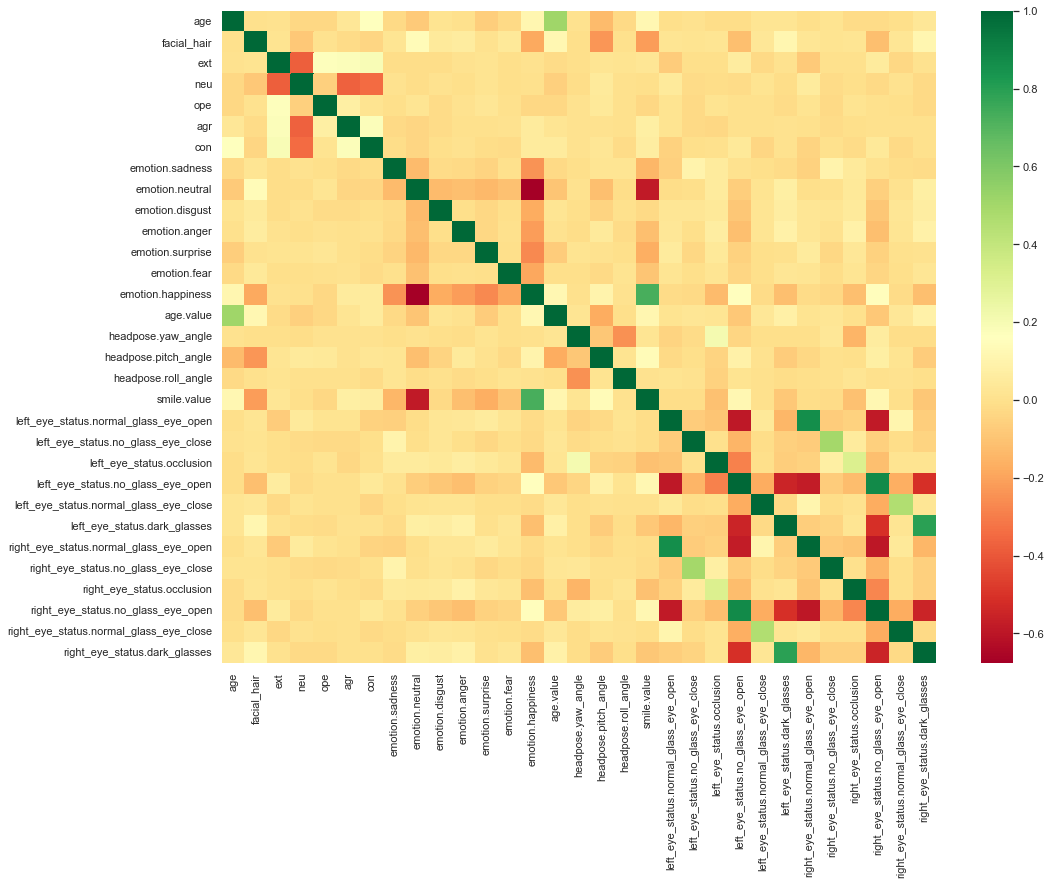

In [100]:
cor_mat = numeric_df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor_mat, cmap='RdYlGn')
plt.savefig(RESULTS_DIR+ 'correlation_plot.png')

# Categorical Data 


In [103]:
#eda for categorical
def cat_eda(cat_df):
    df1 = pd.DataFrame(cat_df.describe().transpose())
    df2 = pd.DataFrame(cat_df.isnull().sum())
    df_final = pd.merge(df1,df2, left_index=True, right_index=True)
    df_final.columns = ('count','unique','top','frequency','missing')
    return df_final

eda_c = cat_eda(nonnumeric_df)

In [104]:
eda_c.head()

,count,unique,top,frequency,missing
gender,31742,2,FEMALE,16000,0
country,31742,3,united states,16000,0
pol,31742,2,liberal,20722,0
database,31742,2,dating,23742,0
gender.value,31742,2,FEMALE,15967,0


In [119]:
###################### Chi-sq test ################################

label_encoder = LabelEncoder()

cat_df_1 = nonnumeric_df.copy()
cin = list(cat_df_1.columns)
for i in cin:
    cat_df_1[i] = label_encoder.fit_transform(cat_df_1[i].astype(str))
    

X = cat_df_1.drop('pol',axis=1)
y = cat_df_1['pol']
chi_scores = chi2(X,y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
print(p_values)

ethnicity.value    8.900604e-08
country            5.893026e-13
gender.value       5.224919e-13
gender             9.882405e-18
database           1.004292e-34
dtype: float64


In [121]:
p_values.iloc[0]

8.900603704488914e-08